In [1]:
# import libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from pywaffle import Waffle

In [2]:
baseUrl = 'https://www.amazon.com'

## Data extraction stage
For faster execution, skip this section to [here](#EDA)

#### Get best sellers list per year

In [258]:
# get list of best sellers per year
info = []
for year in range(2009,2020):
    for i in [1,2]:
        url = 'https://www.amazon.com/gp/bestsellers/{}/books/ref=zg_bsar_pg_2?ie=UTF8&pg={}'.format(year, i)
        headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.157 Safari/537.36'}
        r = requests.get(url, headers = headers)
        soup = BeautifulSoup(r.text, 'lxml')
        books = soup.findAll('li', {'class':'zg-item-immersion'})
        for book in books:
            year = year
            rank = int(book.find('span', {'class':'zg-badge-text'}).text.replace('#',''))
            try:
                title = book.find('img')['alt']
            except TypeError:
                title, author, rating, no_of_reviews, price, link = ['n/a', 'n/a','n/a', 'n/a', 'n/a', 'n/a']
                book_info = {
                'year' : year,
                'rank' : rank,
                'title': title,
                'author': author,
                'rating' : rating,
                'no of reviews' : no_of_reviews,
                'price' : price,
                'link' : link
            }
                info.append(book_info)
                continue
            try:
                author = book.find('a', {'class': 'a-size-small a-link-child'}).text
            except AttributeError:
                try:
                    author = book.find('span', {'class': 'a-size-small a-color-base'}).text
                except AttributeError:
                    author = 'no author listed'
            rating = float(book.find('div', {'class': 'a-icon-row a-spacing-none'}).find('a', {'class':'a-link-normal'})['title'].split(' ')[0])
            no_of_reviews = int(book.find('a', {'class': 'a-size-small a-link-normal'}).text.replace(',',''))
            price = book.find('a', {'class':'a-link-normal a-text-normal'}).text
            link = baseUrl+book.find('a', {'class': 'a-link-normal a-text-normal'})['href']
            book_info = {
                'year' : year,
                'rank' : rank,
                'title': title,
                'author': author,
                'rating' : rating,
                'no of reviews' : no_of_reviews,
                'price' : price,
                'link' : link
            }
            info.append(book_info)
df = pd.DataFrame(info)
# drop books that have been removed from site
authoredDF = df[df['author'] != 'no author listed'].reset_index(drop = True)
authoredDF = authoredDF.astype({'rating':'float', 'no of reviews':'int'})

#### Get genre information (fiction or non-fiction) from www.goodreads.com

In [427]:
f_n = []
for i in range(1030, authoredDF.shape[0]):
    title = authoredDF.loc[i, 'title'].replace(' ', '+')
    url2 = 'https://www.google.com/search?q=goodreads+{}'.format(title)
    r2 = requests.get(url2, headers = headers)
    soup2 = BeautifulSoup(r2.text)
    links = soup2.findAll('a', href = True)
    needed_link = ''
    for link in links:
        if 'www.goodreads.com' in link['href']:
            needed_link = link['href']
            break
    r3 = requests.get(needed_link, headers = headers)
    genre = BeautifulSoup(r3.text).findAll('a', {'class': 'actionLinkLite bookPageGenreLink'})
    genre = [a.text.lower() for a in genre]
    if 'fiction' in genre:
        f_n.append('fiction')
    elif any(['nonfiction' in genre, 'non-fiction' in genre, 'non fiction' in genre]):
        f_n.append('non-fiction')
    else:
        f_n.append('not sure')    
authoredDF['type'] = f_n
# books that have no genre 
unsure = authoredDF[authoredDF['type'] == 'not sure']

# try looking up genre again
f_n2 = []
for i in unsure.index:
    title = authoredDF.loc[i, 'title'].replace(' ', '+')
    url2 = 'https://www.google.com/search?q=goodreads+{}'.format(title)
    r2 = requests.get(url2, headers = headers)
    soup2 = BeautifulSoup(r2.text)
    links = soup2.findAll('a', href = True)
    needed_link = ''
    for link in links:
        if 'www.goodreads.com' in link['href']:
            needed_link = link['href']
            break
    r3 = requests.get(needed_link, headers = headers)
    genre = BeautifulSoup(r3.text).findAll('a', {'class': 'actionLinkLite bookPageGenreLink'})
    genre = [a.text.lower() for a in genre]
    if 'fiction' in genre:
        f_n2.append('fiction')
    elif any(['nonfiction' in genre, 'non-fiction' in genre, 'non fiction' in genre]):
        f_n2.append('non-fiction')
    else:
        f_n2.append('not sure') 
pd.options.mode.chained_assignment = None
unsure['type'] = f_n2
authoredDF_new = authoredDF.copy()
for i in unsure.index:
    authoredDF_new.loc[i, 'type'] = unsure.loc[i, 'type']
aut = authoredDF_new

In [ ]:
# save data
# authoredDF_new.to_csv(r'C:\Users\ADESOYE\Desktop\ML\Hamoye\Stage E\datasets\b.csv', index = False)

#### EDA

In [3]:
# read data henceforth
aut = pd.read_csv('https://raw.githubusercontent.com/adedam0/Hamoye/main/datasets/What%20books%20interest%20the%20masses/amazon%20data.csv')

#### No.1 best sellers for each year

In [4]:
# No.1 best sellers for each year
aut[aut['rank'] == 1].loc[:,['year', 'title', 'author']].reset_index(drop=True)

,year,title,author
0,2009,The Lost Symbol,Dan Brown
1,2010,The Girl Who Kicked the Hornet's Nest (Millenn...,Stieg Larsson
2,2011,Steve Jobs: The Exclusive Biography,Walter Isaacson
3,2012,Fifty Shades Of Grey: Book One of the Fifty Sh...,E L James
4,2013,StrengthsFinder 2.0,Tom Rath
5,2014,StrengthsFinder 2.0,Tom Rath
6,2015,First 100 Words: A Padded Board Book,Roger Priddy
7,2016,"Harry Potter and the Cursed Child, Parts 1 & 2...",J.K. Rowling
8,2017,Wonder,R. J. Palacio
9,2018,Becoming,Michelle Obama


In [5]:
# StrengthsFinder 2.0 occurrences in the dataset
aut[aut['title'] == 'StrengthsFinder 2.0'].loc[:,['year', 'title', 'author']].reset_index(drop=True)

,year,title,author
0,2009,StrengthsFinder 2.0,Tom Rath
1,2010,StrengthsFinder 2.0,Tom Rath
2,2011,StrengthsFinder 2.0,Tom Rath
3,2012,StrengthsFinder 2.0,Tom Rath
4,2013,StrengthsFinder 2.0,Tom Rath
5,2014,StrengthsFinder 2.0,Tom Rath
6,2015,StrengthsFinder 2.0,Tom Rath
7,2016,StrengthsFinder 2.0,Tom Rath
8,2017,StrengthsFinder 2.0,Tom Rath
9,2018,StrengthsFinder 2.0,Tom Rath


#### Books with the most appearances

In [6]:
# most recurring books between lists
count_year = pd.DataFrame(aut[['title', 'author']].value_counts(), columns = ['count']).head(10).reset_index().sort_values('count')
count_year

,title,author,count
5,The Five Dysfunctions of a Team: A Leadership ...,Patrick Lencioni,8
6,The Four Agreements: A Practical Guide to Pers...,Don Miguel Ruiz,8
7,What to Expect When You're Expecting,Heidi Murkoff,8
8,How to Win Friends & Influence People,Dale Carnegie,8
9,Jesus Calling: Enjoying Peace in His Presence ...,Sarah Young,8
3,The Great Gatsby: The Only Authorized Edition,F. Scott Fitzgerald,9
4,"Oh, the Places You'll Go!",Dr. Seuss,9
2,The 7 Habits of Highly Effective People: Power...,Stephen R. Covey,10
0,Publication Manual of the American Psychologic...,American Psychological Association,11
1,StrengthsFinder 2.0,Tom Rath,11


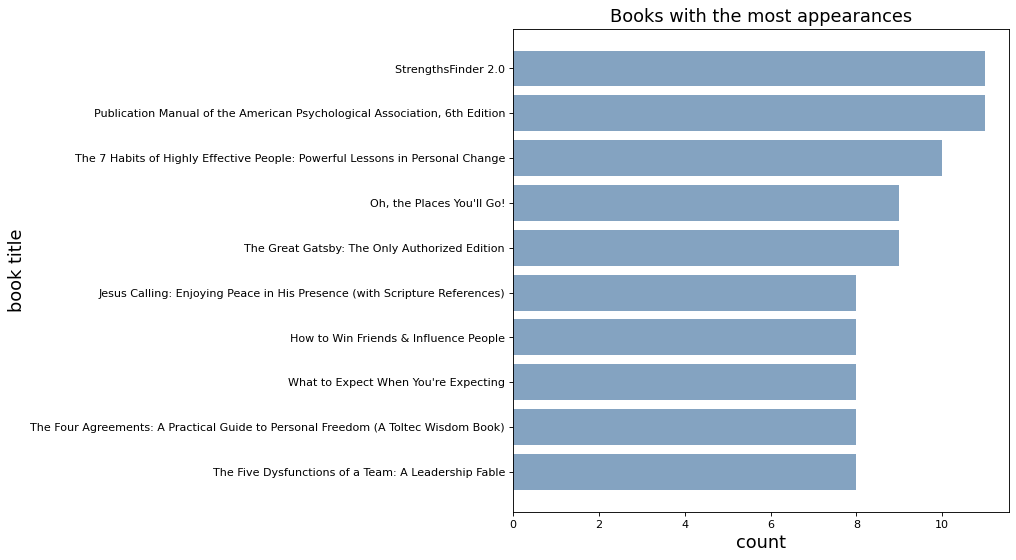

In [47]:
figure(figsize=(8, 8), dpi=80)
plt.barh(count_year['title'], count_year['count'],color=(0.2, 0.4, 0.6, 0.6))
plt.ylabel('book title', fontsize=16)
plt.xlabel('count',fontsize=16)
plt.title('Books with the most appearances', fontsize=16)
plt.show()

#### Top 5 authors with the most amount of book appearances

In [48]:
# most best selling authors features
bs_auth = pd.DataFrame(aut[['author']].value_counts(), columns = ['count']).sort_values('count', ascending = False).reset_index()
# top five best selling authors
bs_top5 = bs_auth.loc[:4]
bs_top5

,author,count
0,Rick Riordan,18
1,Suzanne Collins,16
2,Jeff Kinney,15
3,Tom Rath,14
4,John Grisham,13


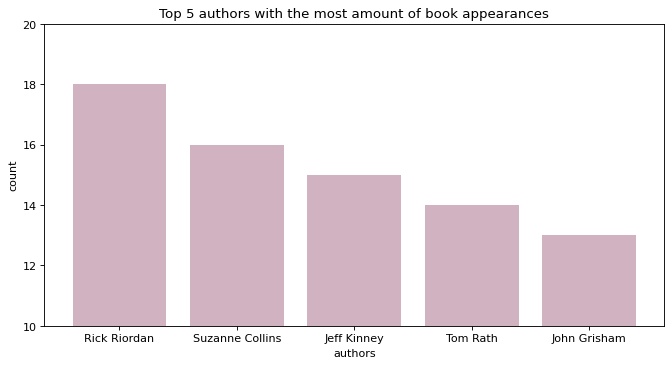

In [49]:
figure(figsize=(10, 5), dpi=80)
plt.bar(bs_top5['author'], bs_top5['count'], color=(0.7, 0.5, 0.6, 0.6))
plt.xlabel('authors')
plt.ylabel('count')
plt.ylim(10,20)
plt.title('Top 5 authors with the most amount of book appearances')
plt.show()

In [10]:
# most recurring best sellers
titlAuth = aut.groupby(['title', 'author'])[['price']].count().sort_values('price', ascending = False)

#### Best selling authors by no. of books' appearances per year

In [11]:
# Best selling authors by no. of books' appearances per year
h = pd.DataFrame(aut[['year','author']].value_counts(), columns = ['count']).sort_values('count', ascending = False).reset_index()
high_p_year = h.groupby('year').first().reset_index()
high_p_year

,year,author,count
0,2009,Stephenie Meyer,7
1,2010,Rick Riordan,5
2,2011,Suzanne Collins,4
3,2012,Suzanne Collins,6
4,2013,E L James,4
5,2014,Veronica Roth,4
6,2015,Johanna Basford,3
7,2016,J.K. Rowling,4
8,2017,Brené Brown,2
9,2018,Wizards RPG Team,4


<ipython-input-12-e5c72af56a81>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.text(x[i], y[i]-1, high_p_year.loc[i, 'author'], ha = 'center',


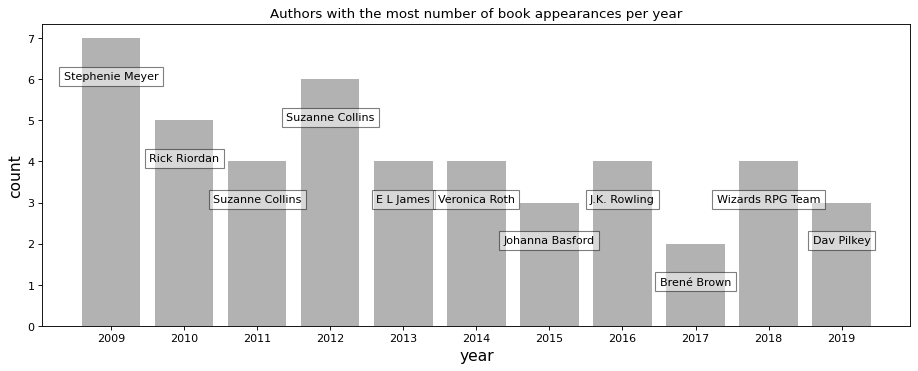

In [12]:
figure(figsize=(14, 5), dpi=80)
plt.bar(high_p_year['year'], high_p_year['count'], color=(0.5, 0.5, 0.5, 0.6))
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i], y[i]-1, high_p_year.loc[i, 'author'], ha = 'center',
                 Bbox = dict(facecolor = 'white', alpha = .5) )
addlabels(high_p_year['year'], high_p_year['count'])
plt.ylabel('count', fontsize = 14)
plt.xlabel('year', fontsize = 14)
plt.xticks(high_p_year['year'])
plt.title('Authors with the most number of book appearances per year')
plt.show()

#### No. of raters vs rating

In [13]:
dist_books = aut.groupby(['title','author']).first().sort_values('rating').reset_index()

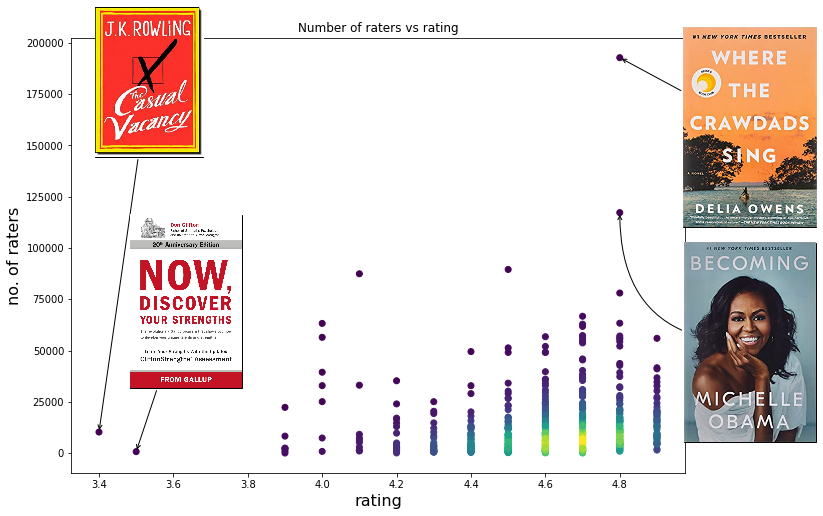

In [155]:
fig, ax = plt.subplots(figsize=(11, 8))
xy = np.vstack([dist_books['rating'], dist_books['no of reviews']])
z = gaussian_kde(xy)(xy)
ax.scatter(dist_books['rating'], dist_books['no of reviews'], c=z)
for i in range(dist_books.shape[0]):
    if dist_books.loc[i, 'title'] == 'Becoming':
        fn = get_sample_data(r"C:\Users\ADESOYE\Desktop\ML\Hamoye\Stage E\datasets\becoming.jpg", asfileobj=False)
        arr_img = plt.imread(fn, format='jpg')

        imagebox = OffsetImage(arr_img, zoom=0.4)
        imagebox.image.axes = ax

        ab = AnnotationBbox(imagebox, (dist_books.loc[i, 'rating'], dist_books.loc[i, 'no of reviews']),
                            xybox=(130., -130.),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0,
                            arrowprops=dict(
                                arrowstyle="->",
                                connectionstyle="angle3,angleA=0,angleB=90")
                            )

        ax.add_artist(ab)
    elif dist_books.loc[i, 'title'] == 'Where the Crawdads Sing':
        fn = get_sample_data(r"C:\Users\ADESOYE\Desktop\ML\Hamoye\Stage E\datasets\crawdads.jpg", asfileobj=False)
        arr_img = plt.imread(fn, format='jpg')

        imagebox = OffsetImage(arr_img, zoom=0.4)
        imagebox.image.axes = ax

        ab = AnnotationBbox(imagebox, (dist_books.loc[i, 'rating'], dist_books.loc[i, 'no of reviews']),
                            xybox=(130., -70.),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0,
                            arrowprops=dict(
                                arrowstyle="->"
                                )
                            )

        ax.add_artist(ab)
    elif dist_books.loc[i, 'title'] == 'The Casual Vacancy':
        fn = get_sample_data(r"C:\Users\ADESOYE\Desktop\ML\Hamoye\Stage E\datasets\vacancy (1).jpg", asfileobj=False)
        arr_img = plt.imread(fn, format='jpg')

        imagebox = OffsetImage(arr_img, zoom=0.3)
        imagebox.image.axes = ax

        ab = AnnotationBbox(imagebox, (dist_books.loc[i, 'rating'], dist_books.loc[i, 'no of reviews']),
                            xybox=(50., 350.),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0,
                            arrowprops=dict(
                                arrowstyle="->"
                                )
                            )

        ax.add_artist(ab)
    elif dist_books.loc[i, 'rating'] == 3.5:
        fn = get_sample_data(r"C:\Users\ADESOYE\Desktop\ML\Hamoye\Stage E\datasets\now.jpg", asfileobj=False)
        arr_img = plt.imread(fn, format='jpg')

        imagebox = OffsetImage(arr_img, zoom=0.08)
        imagebox.image.axes = ax

        ab = AnnotationBbox(imagebox, (dist_books.loc[i, 'rating'], dist_books.loc[i, 'no of reviews']),
                            xybox=(50., 150.),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0,
                            arrowprops=dict(
                                arrowstyle="->"
                                )
                            )

        ax.add_artist(ab)
ax.set_xlabel('rating', fontsize =16)
ax.set_ylabel('no. of raters', fontsize =16)
ax.set_title('Number of raters vs rating')
plt.show()

#### Types of books commonly bought

In [160]:
aut.type.replace('not sure', 'n/a', inplace = True)

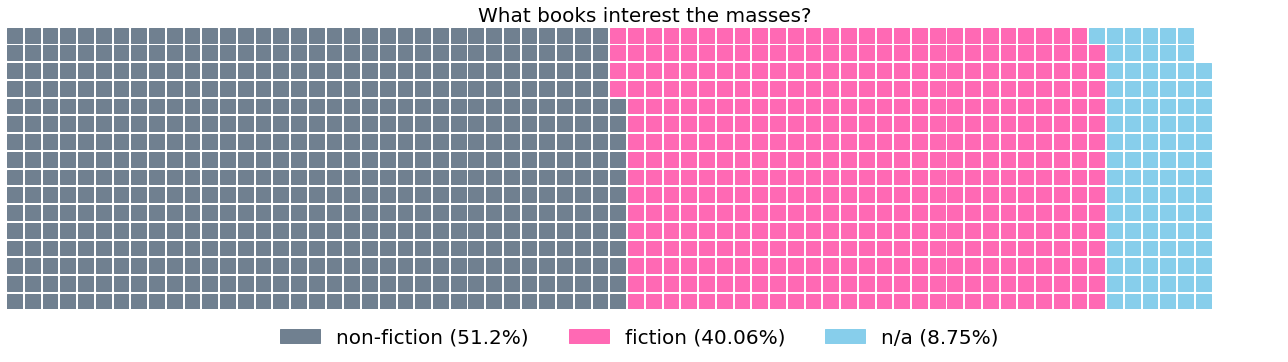

In [174]:
data = dict(aut['type'].value_counts())
fig =plt.figure(FigureClass=Waffle,
                figsize = (18,8),
                columns= 72,
                values = data,
                colors = ['slategray', 'hotpink', 'skyblue'],
                labels=[f"{k} ({round(float(v / sum(data.values()) * 100),2)}%)" for k, v in data.items()],
                legend={
        'loc': 'lower left',
        'bbox_to_anchor': (0.2, -0.2),
        'ncol': 3,
        'framealpha': 0,
        'fontsize': 20
    }
)
plt.title('What books interest the masses?', fontsize = 20)
plt.show()

#### Genre distribution per year

In [162]:
yearC = dict(aut.loc[:,['year', 'type']]['year'].value_counts())
divIyear = pd.DataFrame(aut.loc[:,['year', 'type']].groupby(['year', 'type']).size(), columns= ['counts']).reset_index()
c = dict(divIyear['counts'])
y = dict(divIyear['year'])
prop = [dict(c)[i]/yearC[dict(y)[i]]*100 for i in range(len(c))]
divIyear['prop'] = prop

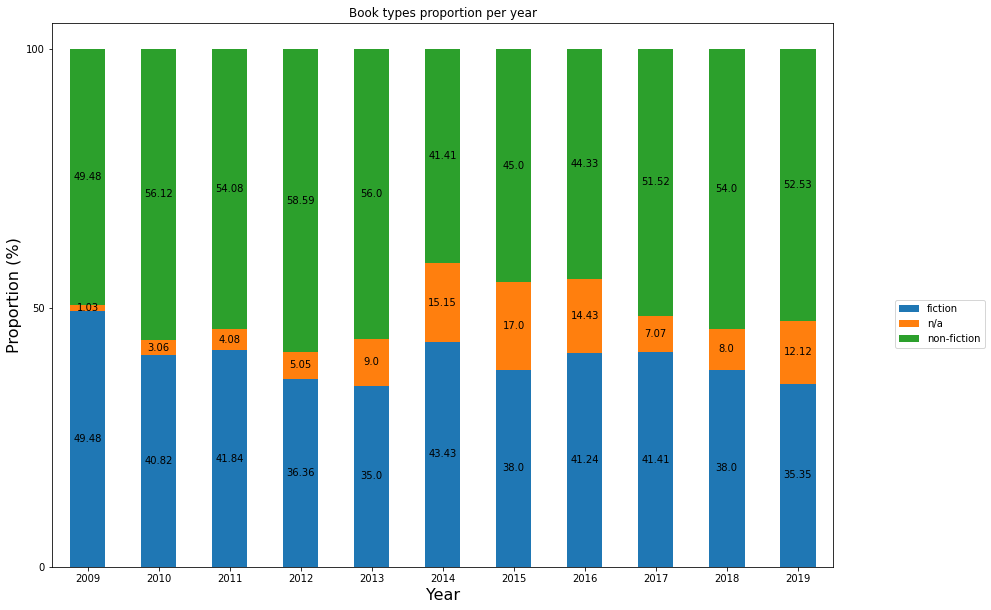

In [168]:
piv = pd.pivot_table(divIyear, values='prop', index=['year'],
                    columns=['type'], aggfunc=np.sum)

ax = piv.plot(kind='bar', stacked=True, figsize=(14, 10), rot=0)

for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [round(v.get_height(), 2) if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')
ax.legend(loc = 'upper right', bbox_to_anchor=(0.7, 0., 0.5, 0.5))
ax.set_title('Book types proportion per year')
ax.set_yticks([0,50,100])
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Proportion (%)', fontsize=16)
plt.show()

#### Average number of raters per rank

In [82]:
G_rank = aut.groupby('rank')['no of reviews'].mean().reset_index()

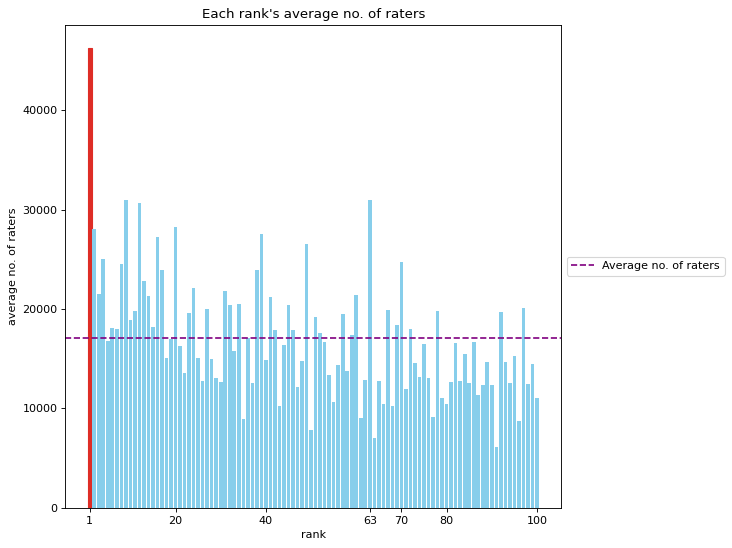

In [170]:
figure(figsize=(8, 8), dpi=80)
b = plt.bar(x =G_rank['rank'], height = G_rank['no of reviews'], color = 'skyblue')
b[0].set_color('#de2d26')
plt.axhline(G_rank['no of reviews'].mean() ,color='purple',  ls='--',  label='Average no. of raters')
plt.xlabel('rank')
plt.ylabel('average no. of raters')
plt.xticks([1, 20, 40, 63, 70,80, 100])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Each rank\'s average no. of raters')
plt.show()

In [183]:
# rank #1's average no. of raters without "Where the Crawdads Sing" and "Becoming"
aut[aut['rank'] == 1].sort_values('no of reviews')[:9]['no of reviews'].mean()

22163.0

#### Average number of raters per year

In [84]:
G_year = aut.groupby('year')['no of reviews'].mean().reset_index()

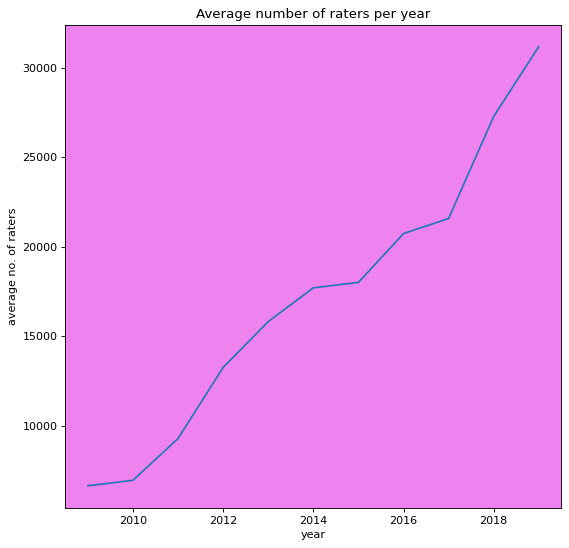

In [157]:
figure(figsize=(8, 8), dpi=80)
x = G_year['year']
y = G_year['no of reviews']
ax = plt.axes()
ax.set_facecolor("violet")
plt.plot(x, y)
plt.xlabel('year')
plt.ylabel('average no. of raters')
plt.title('Average number of raters per year')
plt.show()